In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import json

In [4]:
COVID_DATA_FILE = '../assets/owid-covid-data-2020.csv'

df = pd.read_csv(COVID_DATA_FILE)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [18]:
df_covid_tweets = pd.read_csv('./covid_tweets_analysis/covid_tweets_by_politician.csv')
df_covid_tweets['created at'] = pd.to_datetime(df_covid_tweets['created at'], utc= True).dt.date

df_non_covid_tweets = pd.read_csv('./covid_tweets_analysis/non_covid_tweets_by_politician.csv')
df_non_covid_tweets['created at'] = pd.to_datetime(df_non_covid_tweets['created at'], utc= True).dt.date

start_date = pd.to_datetime('01/1/2020', utc= True)
end_date = pd.to_datetime('12/31/2020', utc= True)

df_covid_tweets = df_covid_tweets.loc[(df_covid_tweets['created at'] >= start_date) & (df_covid_tweets['created at'] <= end_date)]
df_covid_tweets = df_covid_tweets.pivot_table(index=['created at'], aggfunc='size')
df_covid_tweets = df_covid_tweets.reindex(pd.date_range('01/1/2020', '12/31/2020'), fill_value=0)
df_covid_tweets = pd.DataFrame({'date': df_covid_tweets.index, 'tweets': df_covid_tweets.values})

df_non_covid_tweets = df_non_covid_tweets.loc[(df_non_covid_tweets['created at'] >= start_date) & (df_non_covid_tweets['created at'] <= end_date)]
df_non_covid_tweets = df_non_covid_tweets.pivot_table(index=['created at'], aggfunc='size')
df_non_covid_tweets = df_non_covid_tweets.reindex(pd.date_range('01/1/2020', '12/31/2020'), fill_value=0)
df_non_covid_tweets = pd.DataFrame({'date': df_non_covid_tweets.index, 'tweets': df_non_covid_tweets.values})

all_tweets = pd.concat([df_covid_tweets.assign(dataset='covid_tweets'), df_non_covid_tweets.assign(dataset='non_covid_tweets')])

df_covid_tweets_cumulated = df_covid_tweets.copy()
df_covid_tweets_cumulated['tweets'] = df_covid_tweets_cumulated['tweets'].cumsum(axis = 0)

In [24]:
HASHTAGS_FILE = './tweet_entities_analysis/all_tweets/hashtags_all_tweets.csv'

df_hashtags = pd.read_csv(HASHTAGS_FILE)
df_hashtags['date'] = pd.to_datetime(df_hashtags['date'], utc= True).dt.date

def get_hashtag_count_by_day(hashtag_df, hashtag):
    hashtag_df = hashtag_df.loc[(hashtag_df['date'] >= start_date) & (hashtag_df['date'] <= end_date) & (hashtag_df['hashtag'] == hashtag)]
    hashtag_df = hashtag_df.pivot_table(index=['date'], aggfunc='size')
    hashtag_df = hashtag_df.reindex(pd.date_range('01/1/2020', '12/31/2020'), fill_value=0)
    hashtag_df = pd.DataFrame({'date': hashtag_df.index, 'hashtag_count': hashtag_df.values})
    return hashtag_df

In [28]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [30]:
def hashtag_over_time(hashtag):
    plt.figure(figsize=(25,8))
    ax = sns.lineplot(data=df.loc[df['location'] == 'Germany'],
                    x='date',
                    y='new_cases',
                    color='grey')
    ax2 = ax.twinx()
    sns.lineplot(data=get_hashtag_count_by_day(df_hashtags, hashtag),
                x='date',
                y='hashtag_count',
                ax=ax2)
    plt.title('Number of New Covid-19 Cases per day (Germany) throughout 2020 / Number of #Corona per day', fontsize=20)
    plt.xlabel('month', fontsize=15)
    ax.yaxis.set_major_formatter(EngFormatter(places=1))
    ax.set_ylabel('number of new cases', fontsize=15)
    ax2.set_ylabel('number of #', fontsize=15)
    plt.show()

interact(hashtag_over_time, hashtag=['#Corona', '#Covid'])

interactive(children=(Dropdown(description='hashtag', options=('#Corona', '#Covid'), value='#Corona'), Output(…

<function __main__.hashtag_over_time(hashtag)>

In [32]:
def covid_vs_twitter(location):
    plt.figure(figsize=(25,8))
    ax = sns.lineplot(data=df.loc[df['location'] == location],
                    x='date',
                    y='new_cases',
                    color='grey')
    ax2 = ax.twinx()
    sns.lineplot(data=all_tweets,
                x='date',
                y='tweets',
                style='dataset',
                ax=ax2)
    plt.title(f'Number of New Covid-19 Cases per day ({location}) throughout 2020 / Tweets per Day', fontsize=20)
    plt.xlabel('month', fontsize=15)
    ax.yaxis.set_major_formatter(EngFormatter(places=1))
    ax.set_ylabel('number of new cases', fontsize=15)
    ax2.set_ylabel('number of tweets', fontsize=15)
    plt.show()

locations_list = df['location'].unique()

interact(covid_vs_twitter, location=locations_list, value='Germany')

interactive(children=(Dropdown(description='location', options=('Afghanistan', 'Albania', 'Algeria', 'Andorra'…

<function __main__.covid_vs_twitter(location)>

In [34]:
from pytrends.request import TrendReq
import pycountry

def get_trend_for_hashtag(hashtag, time_frame, location):
    pytrends = TrendReq(hl='de', tz='60', timeout=(10, 60))
    hashtag = hashtag.strip('#')
    kw_list = [hashtag]
    pytrends.build_payload(kw_list, timeframe=time_frame, geo=location)
    return pytrends.interest_over_time()

In [36]:
fig = None

def covid_dashboard(location, show_case_numbers, show_covid_tweets, show_non_covid_tweets, hashtag, show_hashtag):
    global fig
    fig, ax = plt.subplots(figsize=(25, 10))

    if show_case_numbers:
        sns.lineplot(data=df.loc[df['location'] == location],
                     x='date',
                     y='new_cases',
                     color='black',
                     label='Daily New Cases',
                     legend=None,
                     ax=ax)
        ax.yaxis.set_major_formatter(EngFormatter(places=1))
        ax.set_ylabel('Number of Daily New Cases', fontsize=15)

    if show_covid_tweets or show_non_covid_tweets:
        ax2 = ax.twinx() if ax is not None else plt.subplot()
        if show_covid_tweets:
            sns.lineplot(data=df_covid_tweets,
                         x='date',
                         y='tweets',
                         color='tab:blue',
                         marker='s',
                         label='COVID Tweets',
                         legend=None,
                         ax=ax2)
        if show_non_covid_tweets:
            sns.lineplot(data=df_non_covid_tweets,
                         x='date',
                         y='tweets',
                         color='tab:orange',
                         linestyle='dashed',
                         label='Non-COVID Tweets',
                         legend=None,
                         ax=ax2)
        ax2.set_ylabel('Number of Tweets', fontsize=15)

    if show_hashtag:
        ax3 = ax.twinx() if ax is not None else plt.subplot()
        sns.lineplot(data=get_hashtag_count_by_day(df_hashtags, hashtag),
                     x='date',
                     y='hashtag_count',
                     color='tab:green',
                     marker='o',
                     label='Hashtag Count',
                     legend=None,
                     ax=ax3)
        ax3.set_ylabel(f'Count of {hashtag}', fontsize=15)
        ax3_margin = 1.05 if show_covid_tweets or show_non_covid_tweets else 1.0
        ax3.spines['right'].set_position(('axes', ax3_margin))

    plt.title('COVID-19 Dashboard', fontsize=20)
    plt.xlabel('month', fontsize=15)
    fig.legend(loc='upper right', bbox_to_anchor=(-0.29, 0.38, 0.5, 0.5))
    plt.show()

locations_dropdown = widgets.Dropdown(options=df['location'].unique(), value='Germany', description='Location')
show_case_numbers_cb = widgets.Checkbox(value=True, description='Show case numbers')
show_covid_tweets_cb = widgets.Checkbox(value=True, description='Show COVID tweets')
show_non_covid_tweets_cb = widgets.Checkbox(value=True, description='Show non-COVID tweets')
hashtag_dropdown = widgets.Dropdown(options=['#Corona', '#Covid' , '#Coronavirus'], value='#Corona', description='Hashtag')
show_hashtag_cb = widgets.Checkbox(value=True, description='Show hashtag')
save_fig_btn = widgets.Button(description='Save figure', icon='save')

def on_button_clicked(btn):
    fig.savefig('test_fig.png')

save_fig_btn.on_click(on_button_clicked)

widget = interactive(covid_dashboard,
                     location=locations_dropdown,
                     show_case_numbers=show_case_numbers_cb,
                     show_covid_tweets=show_covid_tweets_cb,
                     show_non_covid_tweets=show_non_covid_tweets_cb,
                     hashtag=hashtag_dropdown,
                     show_hashtag=show_hashtag_cb
                    )

control_widgets = tuple([wc for wc in widget.children[:-1]] + [save_fig_btn])
controls = widgets.HBox(control_widgets, layout=widgets.Layout(flex_flow='row wrap'))
output = widget.children[-1]
display(widgets.VBox([controls, output]))

In [38]:
fig = None

def covid_dashboard(location, show_case_numbers, show_covid_tweets, show_non_covid_tweets, hashtag, show_hashtag, show_google_trends):
    global fig
    fig, ax = plt.subplots(figsize=(25, 10))

    if show_case_numbers:
        sns.lineplot(data=df.loc[df['location'] == location],
                     x='date',
                     y='new_cases',
                     color='black',
                     label='Daily New Cases',
                     legend=None,
                     ax=ax)
        ax.yaxis.set_major_formatter(EngFormatter(places=1))
        ax.set_ylabel('Number of Daily New Cases', fontsize=15)

    if show_covid_tweets or show_non_covid_tweets:
        ax2 = ax.twinx() if ax is not None else plt.subplot()
        if show_covid_tweets:
            sns.lineplot(data=df_covid_tweets,
                         x='date',
                         y='tweets',
                         color='tab:blue',
                         marker='s',
                         label='COVID Tweets',
                         legend=None,
                         ax=ax2)
        if show_non_covid_tweets:
            sns.lineplot(data=df_non_covid_tweets,
                         x='date',
                         y='tweets',
                         color='tab:orange',
                         linestyle='dashed',
                         label='Non-COVID Tweets',
                         legend=None,
                         ax=ax2)
        ax2.set_ylabel('Number of Tweets', fontsize=15)

    if show_hashtag:
        ax3 = ax.twinx() if ax is not None else plt.subplot()
        sns.lineplot(data=get_hashtag_count_by_day(df_hashtags, hashtag),
                     x='date',
                     y='hashtag_count',
                     color='tab:green',
                     marker='o',
                     label='Hashtag Count',
                     legend=None,
                     ax=ax3)
        ax3.set_ylabel(f'Count of {hashtag}', fontsize=15)
        ax3_margin = 1.05 if show_covid_tweets or show_non_covid_tweets else 1.0
        ax3.spines['right'].set_position(('axes', ax3_margin))

    if show_google_trends:
        ax4 = ax.twinx() if ax is not None else plt.subplot()
        country_code = pycountry.countries.get(name=location).alpha_2
        trends_df = get_trend_for_hashtag(hashtag=hashtag,
                                        time_frame='2020-01-01 2020-12-31',
                                        location=country_code).reset_index()
        sns.lineplot(data=trends_df,
                    x='date',
                    y=hashtag.strip('#'),
                    color='tab:red',
                    marker='v',
                    label='Google Trend',
                    legend=None,
                    ax=ax4)
        ax4.set_ylabel(f'Number of Google Searches for {hashtag} in {location}', fontsize=15)
        ax4_margin = 1.10
        if show_hashtag and not show_covid_tweets and not show_non_covid_tweets:
            ax4_margin = 1.05
        if not show_hashtag and not show_covid_tweets and not show_non_covid_tweets:
            ax4_margin = 1.0
        ax4.spines['right'].set_position(('axes', ax4_margin))

    plt.title('COVID-19 Dashboard', fontsize=20)
    plt.xlabel('month', fontsize=15)
    fig.legend(loc='upper right', bbox_to_anchor=(-0.29, 0.38, 0.5, 0.5))
    plt.show()

locations_dropdown = widgets.Dropdown(options=df['location'].unique(), value='Germany', description='Location')
show_case_numbers_cb = widgets.Checkbox(value=True, description='Show case numbers')
show_covid_tweets_cb = widgets.Checkbox(value=True, description='Show COVID tweets')
show_non_covid_tweets_cb = widgets.Checkbox(value=True, description='Show non-COVID tweets')
hashtag_dropdown = widgets.Dropdown(options=['#Corona', '#Covid' , '#Coronavirus'], value='#Corona', description='Hashtag')
show_hashtag_cb = widgets.Checkbox(value=True, description='Show hashtag')
show_google_trends_cb = widgets.Checkbox(value=True, description='Show Google Trend for #')
save_fig_btn = widgets.Button(description='Save figure', icon='save')

def on_button_clicked(btn):
    fig.savefig('test_fig.png')

save_fig_btn.on_click(on_button_clicked)

widget = interactive(covid_dashboard,
                     location=locations_dropdown,
                     show_case_numbers=show_case_numbers_cb,
                     show_covid_tweets=show_covid_tweets_cb,
                     show_non_covid_tweets=show_non_covid_tweets_cb,
                     hashtag=hashtag_dropdown,
                     show_hashtag=show_hashtag_cb,
                     show_google_trends=show_google_trends_cb
                    )

control_widgets = tuple([wc for wc in widget.children[:-1]] + [save_fig_btn])
controls = widgets.HBox(control_widgets, layout=widgets.Layout(flex_flow='row wrap'))
output = widget.children[-1]
display(widgets.VBox([controls, output]))

In [40]:
EVENTS_FILE = '../assets/events_covid.json'

with open(EVENTS_FILE, 'r', encoding='utf-8') as events_infile:
    events = json.load(events_infile)

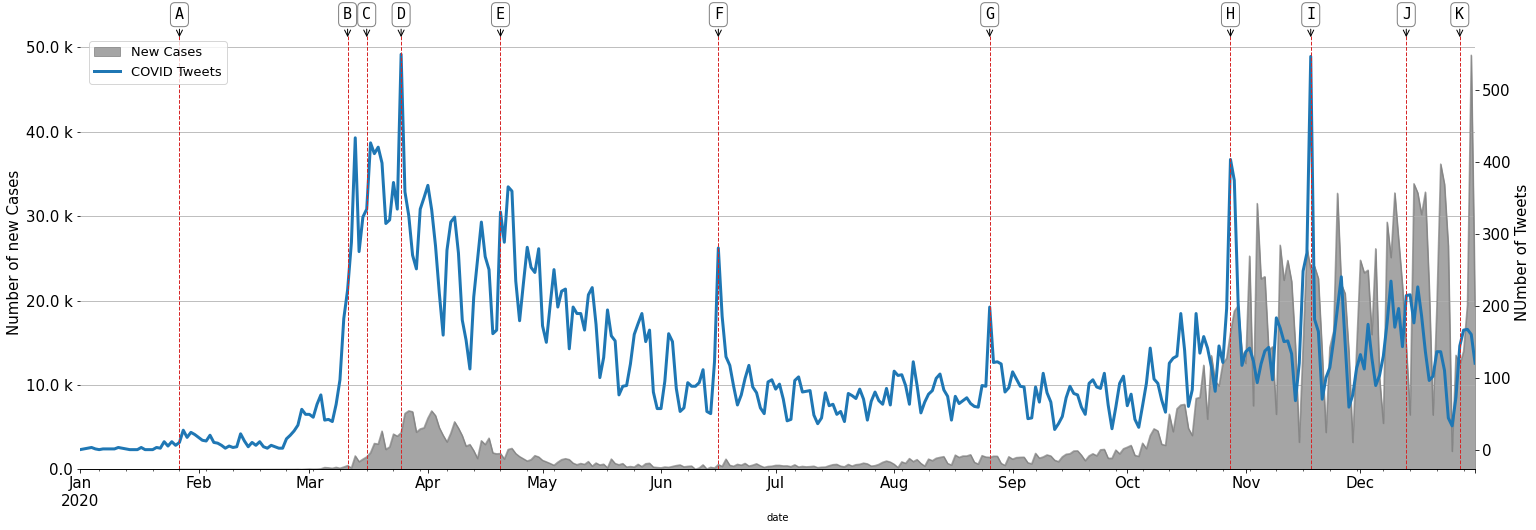

In [47]:
fig, ax = plt.subplots(figsize=(25,8))
df.loc[df['location'] == 'Germany'].plot.area(x='date',
                                              y='new_cases',
                                              label='New Cases',
                                              legend=None,
                                              color='tab:gray',
                                              alpha=0.7,
                                              ax=ax)
ax.yaxis.set_major_formatter(EngFormatter(places=1))
ax.set_ylabel('Number of new Cases', fontsize=15)
ax2 = ax.twinx()
df_covid_tweets.plot.line(x='date',
                          y='tweets',
                          label='COVID Tweets',
                          legend=None,
                          color='tab:blue',
                          linewidth=3,
                          ax=ax2)
ax2.set_ylabel('NUmber of Tweets', fontsize=15)
for i, e in enumerate(events):
    ax2.axvline(pd.to_datetime(e['date']),
                               color='tab:red',
                               linestyle='--',
                               lw=1)
    ax2.annotate(chr(ord('@') + i + 1),
                 xy=(pd.to_datetime(e['date']), 570),
                 bbox=dict(boxstyle='round', fc='none', ec='gray'),
                 xytext=(0, 20),
                 textcoords='offset points',
                 ha='center',
                 arrowprops=dict(arrowstyle='->'),
                 annotation_clip=False,
                 fontsize=15,
                 fontfamily='monospace')

# plt.title('Number of New Covid-19 Cases per day (Germany) throughout 2020 / Number of #Corona per day', fontsize=20, y=1.08)
plt.xlabel('month', fontsize=15)
ax.tick_params(labelsize=15)
ax2.tick_params(labelsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

ax.grid(True, axis='y')

fig.legend(loc='upper right', bbox_to_anchor=(-0.29, 0.38, 0.5, 0.5), prop={'size': 13})
plt.show()